In [1]:
pip install deepxde

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


Using backend: tensorflow



In [2]:
def heat_eq_exact_solution(x, t): #For sinusoidal initial conditions
    return np.exp(-(n**2*np.pi**2*a*t)/(L**2))*np.sin(n*np.pi*x/L)

def gen_exact_solution():

    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)
    # x_dim, t_dim = (4, 4)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.)
    x_max, t_max = (L, 1.)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i],t[j])
    
    # Save solution:
    np.savez('heat_eq_data', x=x, t=t, usol=usol)
    data = np.load('heat_eq_data.npz')


def gen_testdata(): # Import the dataset with the exact solution
    data = np.load('heat_eq_data.npz')
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]

    # print(data["usol"])
    # print(exact)
    # print(x)
    # print(t)
    # print(xx)
    # print(tt)
    # print(np.ravel(xx))
#     print(X)
#     print(X.shape)
    # print(exact.flatten())
    # print(y)
    return X, y

def main():

    # Express the PDE residual of the heat equation:
    def pde(x, y):
        dy_t = dde.grad.jacobian(y, x, i=0, j=1)
        dy_xx = dde.grad.hessian(y, x, i=0, j=0)
        return dy_t - a*dy_xx

    # Computational geometry:
    geom = dde.geometry.Interval(0, L)
#     print(geom)
    timedomain = dde.geometry.TimeDomain(0, 1)
#     print(timedomain)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
#     print(geomtime)


    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L), lambda _, on_initial: on_initial
        )

    # Define the PDE problem and configurations of the network:
    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], num_domain=600, num_boundary=80, num_initial=160
    )
#     print(data.train_points())
#     print(data.train_points().shape)
    net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # Built/train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    # Plot/print the results
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    X, y_true = gen_testdata()
    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))



In this code we will solve the heat equation using PINN implemented with the DeepXDE library.

The equation is as follows:

$\frac{\partial u}{\partial t} = \alpha \nabla^2 u\;$ .

Where $\nabla^2$ is the laplacian differential operator, $\alpha$ is the thermal diffusivity constant and $u$ is the function (temperature) we want to approximate.

In a unidimensional case we have:

$\frac{\partial u(x, t)}{\partial t}$ = $\alpha \frac{\partial^2u(x,t)}{{\partial x}^2}\;$, $\;\;\;\; x \in [0, 1]\;$, $\;\;\;\; t \in [0, 1]\;$.

With Dirichlet boundary conditions 

$u(0, t) = u(1, t) = 0\;$ , 

and periodic (sinoidal) initial conditions:

$u(x, 0) = sin(n\pi x/L)\;$, $\;\;\;\; 0 < x < L\;$, $\;\;\;\; n = 1, 2, ...\;.$

This setup is a common problem in many differential equations textbooks and can be physically interpreted as the variation of temperature in a uniform and unidimensional bar over time. Here, the constant $\alpha$ is the thermal diffusivity (a property of the material that the bar is made) and $L$ is the lenght of the bar.



Compiling model...
'compile' took 0.000460 s

Training model...

Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x000002832DA50550>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x000002832DA50550>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x000002832DA50B80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x000002832DA50B80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                      

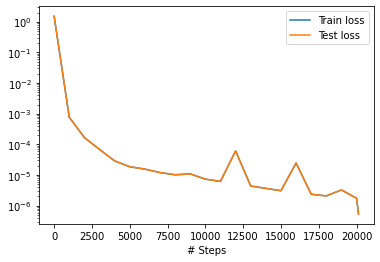

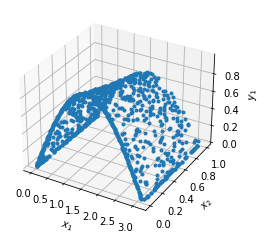

Mean residual: 0.0005208167
L2 relative error: 0.0001907632434424708


In [3]:
if __name__ == "__main__":

    # Problem parameters:
    a = 0.4 # Thermal diffusivity
    L = np.pi # Lenght of the bar
    n = 1 # Frequency of the sinusoidal initial conditions

    # Generate a dataset with the exact solution (if you dont have one):
    gen_exact_solution()
    # gen_testdata()

    # Solve the equation:
    main()
    